## [dyskinesia project] SCRATCHPAD

This notebooks will not be part of the actual workflow but is to play around and debug.



### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
from abc import ABCMeta, abstractmethod
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

#mne
import mne_bids
import mne

# Models for py_nmd bids example
from sklearn import linear_model, metrics, model_selection

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne_bids', mne_bids.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)

Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas 1.3.4
numpy 1.20.3
mne_bids 0.9
mne 0.24.1
sci-py 1.7.1
sci-kit learn 1.0.1


In [3]:
# define local storage directories
projectpath = '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'
codepath = os.path.join(projectpath, 'code')
pynmd_path = os.path.join(codepath, 'py_neuromodulation')
rawdatapath = '/Users/jeroenhabets/OneDrive - Charité - Universitätsmedizin Berlin/BIDS_Berlin_ECOG_LFP/rawdata'

# define external storage directories
ext_projectpath = '/Volumes/JH/Research/CHARITE/projects/dyskinesia_neurophys'
ext_datapath = os.path.join(ext_projectpath, 'data/BIDS_Berlin_ECOG_LFP/rawdata')

# change working directory to project-code folder
os.chdir(codepath)
os.getcwd()

'/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code'

In [4]:
# import py_neuromodulation after defining relevant directories

from py_neuromodulation import nm_BidsStream, nm_analysis

import lfpecog_preproc.preproc_data_management as dataMng
import lfpecog_preproc.preproc_reref as reref
import lfpecog_preproc.preproc_artefacts as artefacts
import lfpecog_preproc.preproc_filters as fltrs
import lfpecog_preproc.preproc_resample as resample


### 1. Patient and Recording definition

In [10]:
# DEFINE PTATIENT-RUN SETTINGS
sub = '008'
ses = 'EphysMedOn02'
task = 'Rest'
acq = 'StimOffLD00'
run = '01'
sourcepath = ext_datapath

In [ ]:
# TODO's
# use same RunInfo Classes as in Preprocessing
# change session-folder for processed data within pt-folder
# change proc-data-filenames to incl pt (plus session?) info?
# include level and electrode names into saved files

In [ ]:
# NEW function to load names and data
# requires runInfo
importlib.reload(preproc)
chdata, chnames = preproc.read_preprocessed_data(runInfo0)

In [140]:
run_str = f'{sub}_{ses}_{task}_{acq}_{run}'
run_dir = os.path.join(
    projectpath,
    f'data/preprocessed/sub-{sub}',
    run_str)
run_files = os.listdir(run_dir)

In [ ]:
# Load npy-files over function
importlib.reload(preproc)
chdata, chnames = preproc.read_preprocessed_data(runInfo0)


In [38]:
# Load npy-files
temp = {}
for f in run_files:
    group = f.split('_')[-1][:-4]
    if group != 'ecog':
        group = 'lfp_' + group
    group = group.upper()
    temp[group] = np.load(os.path.join(run_dir, f))


In [77]:
for g in temp:
    print(temp[g].shape)

(611, 7, 800)
(611, 6, 800)
(611, 5, 800)


In [84]:
dat = temp['ECOG']
dat.shape

(611, 7, 800)

In [94]:
scipy.signal.periodogram(temp[g][0, 1:, :], fs=800, )[1].shape

(4, 401)

In [130]:
psds, zpsds = {}, {}
ch_means, ch_zmeans = {}, {}
for g in temp.keys():
    dat = temp[g]
    psds[g] = np.empty((dat.shape[0], dat.shape[1] - 1, int(dat.shape[2] / 2) + 1))
    zpsds[g] = np.empty_like(psds[g])
    for w in np.arange(dat.shape[0]):
        f, ps = scipy.signal.periodogram(dat[w, 1:, :], fs=800, )
        psds[g][w, :, :] = ps

    for r in np.arange(psds[g].shape[1]):
        m = np.mean(psds[g][r])
        sd = np.std(psds[g][r])
        zpsds[g][r] = (psds[g][r] - m) / sd

    ch_means[g] = np.nanmean(zpsds[g], axis=0)
    ch_zmeans[g] = np.nanmean(zpsds[g], axis=0)



In [176]:
if 3 in t.test: t.test.remove(3)
t.test

[0, 2]

In [169]:
@dataclass
class Test:
    test: list

t = Test([0, 1, 2, 3])

t.test.remove(1)

t

Test(test=[0, 2, 3])

In [125]:
dat =  ch_means["ECOG"]
for r in np.arange(dat.shape[0]):
    m = np.mean(dat[r])
    sd = np.std(dat[r])
    dat[r] = (dat[r] - m) / sd

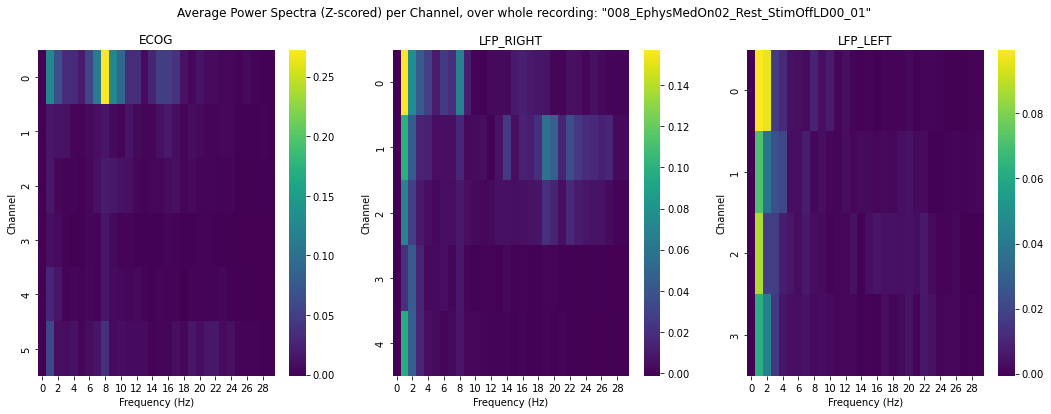

In [149]:
def mean_channel_freqs()
"""
Create for every source a mean Power Spectogram per Channel.
Within each recording, the PSD's over all windows are averaged.
Visualizes a rough overview of freq-bandwidth presence in
different channels.
Can be used for channel selection
"""

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for n, g in enumerate(ch_zmeans.keys()):
    sns.heatmap(ch_zmeans[g][:, :30], cmap='viridis', ax=axes[n])
    axes[n].set_title(g)
    axes[n].set_ylabel('Channel')
    axes[n].set_xlabel('Frequency (Hz)')
plt.suptitle('Average Power Spectra (Z-scored) per Channel'
         f', over whole recording: "{run_str}"')
plt.show()

<AxesSubplot:>

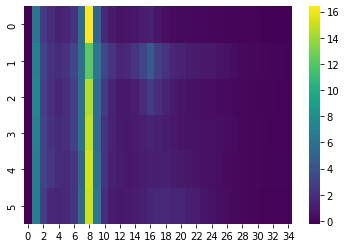

In [127]:
# ch means normalized
sns.heatmap(dat[:, :35], cmap='viridis')

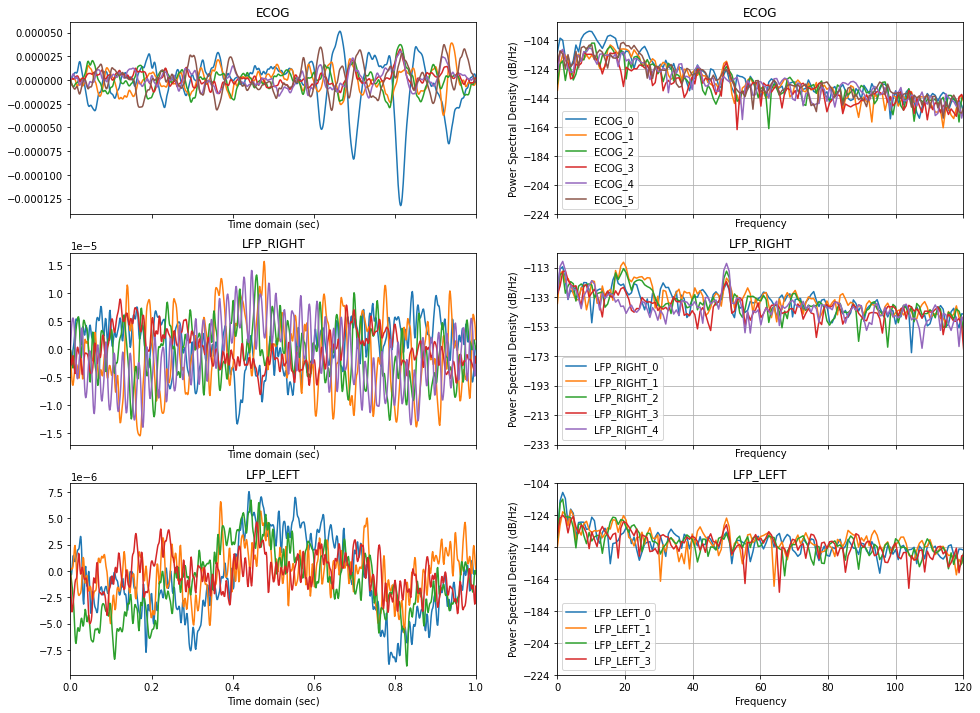

In [79]:
fig, axes = plt.subplots(len(temp.keys()), 2, sharex='col', figsize=(16,12))
for n, g in enumerate(temp):
    x = temp[g][0, 0, :].reshape(temp[g].shape[2], 1)
    y = temp[g][0, 1:, :].T
    # Raw
    axes[n, 0].plot(x, y)
    axes[n, 0].set_xlabel('Time domain (sec)')
    axes[n, 0].set_title(g)
    axes[n, 0].set_xlim(0, 1)
    # PSD
    for s in np.arange(y.shape[1]):
        axes[n, 1].psd(y[:, s], NFFT=1024, Fs=800, label=f'{g}_{s}')
    axes[n, 1].set_xlim(0, 120)
    axes[n, 1].set_title(g)
    axes[n, 1].legend()

plt.show()

### 2. Settings of Feature Extraction ??

In [351]:
# APERIODIC EXPONENT
from fooof import FOOOF  # https://fooof-tools.github.io/fooof/

# cycle-by-cyle estimates
# neurodsp == 1.0.0  # install/import
# # neurodsp is a toolbox for digital signal processing for neural time series
# bycycle == 0.1.3  # install/import
# # bycycle is a toolbox for cycle-by-cycle analyses of neural oscillations

In [79]:
f, psd = signal.welch(
x=ecog250[3][0:125],
fs=250,
window='hann',
nperseg=125,
noverlap=None,
nfft=F,
)

psd.shape

(513,)

In [95]:
## Wavelet Decomposition
power = mne.time_frequency.tfr_morlet(
    epochs, 
    freqs=freqs, 
    n_cycles=n_cycles, 
    return_itc=False, 
    picks='ecog', 
    n_jobs=-1
)

(513,)
(1026,)
(4, 513)
(513,)


#### Pro Memori: Annotations and Events

In [ ]:
# check:
events, event_id = mne.events_from_annotations(raw, event_id={"EMG_onset": 1})
epochs = mne.Epochs(raw, events=events, tmin=-5, tmax=5, baseline=None)

#### - Feature extraction and visualization

In [ ]:
freqs = np.arange(1, 100)
n_cycles = 5

#### Pro Memori: Involve py_neuromodulation-functions in Signal Analysis